# Background

This Notebook is an extension of PySINDy-MPC (SINDy with control), which organises the functions in one MPC class, groups all important parameters in one block, and most importantly apply PySINDy-MPC to three different problems - Chaotic Lorenz, Simple Population Dynamics, and HIV Therapeutic Stragegy model.

Model Predictive Control has been a long-standing subject of research and has found practical application across various domains. Nevertheless, a prevalent issue with these control strategies that rely on models is their significant reliance on accurately modeling dynamic systems, usually based on pre-established dynamics. The introduction of the SINDy algorithm in 2016<sup>[1]</sup> marked a significant shift. This algorithm enables the identification of profoundly nonlinear dynamics through the SINDy framework, eliminating the need for extensive datasets. This is particularly advantageous in real-life situations where low-data limit is prominent<sup>[2]</sup>, owing to the framework's strong generalisation capabilities<sup>[3]</sup> and low computational costs. The equation below shows the model learned with SINDy algorithm, consisting a model coefficient term and feature library term.

\begin{equation}
    \dot{X}=Θ(X)Ξ \label{eq:SINDy}
\end{equation}

Extensively developed in the 1980s, model predictive control employs online learning to forecast the subsequent N steps of states (referred to as the horizon) using $\dot{X}$. Within this horizon, a cost function is assigned. This function incorporates a weighted calculation of the disparity between the current state and the desired state (measured as ||current - target state||) along with the amount of control effort. By striking a balance between these factors, an optimal sequence of controls can be determined at each step. This approach has demonstrated remarkable efficacy, particularly when addressing constraints and obstacles within the optimisation problem. In this illustration, both the control and the prediction interval are aligned for simplicity, and a linear quadratic cost function is employed.
$$\begin{aligned} \min _{\hat{\mathbf{u}}\left(\cdot \mid \mathbf{x}_j\right)} J\left(\mathbf{x}_j\right)= & \min _{\hat{\mathbf{u}}\left(\cdot \mid \mathbf{x}_j\right)}\left[\sum_{k=0}^{N}\left\|\hat{\mathbf{x}}_{j+k}-\mathbf{x}_k^*\right\|_{\mathbf{Q}}^2\right.\left.+\sum_{k=0}^{N-1}\left(\left\|\hat{\mathbf{u}}_{j+k}\right\|_{\mathbf{R}}^2\right)\right]\end{aligned}$$

In this notebook, the CASADI python library, a symbolic framework for numerical optimisation is used due to its flexibility and customisation, active open-source community, and the popularity among academics.

<div style="border: 1px solid #ddd; padding: 10px; border-radius: 5px; background-color: #FFFFFF;">
  <h2 style="margin-bottom: 10px;">Table of Contents</h2>
  <ol style="list-style-type: decimal; padding-left: 20px;">
    <li><a href="#motivation">Motivation</a></li>
    <li><a href="#system-identification">System Identification</a></li>
    <li><a href="#mpc">Model Predictive Control</a></li>
    <li><a href="#results-and-visualisation">Results and Visualisation</a></li>
    <li><a href="#reference">Reference</a></li>
  </ol>
</div>

# Dependencies

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import casadi as ca
from itertools import combinations_with_replacement
from time import time
from functools import partial

import pysindy as ps
from pysindy.utils import lorenz_control

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# plt.style.use("dark_background")

# SINDy in Symbolic Form <a id="sindy-symbolic"></a>

To solve the optimisation problem, the system dynamics which is the Chaotic Lorenz system would have to be represented symbolically. Traditionally, without using SINDy algorithm, the system can be represented easily with only 2-3 terms (in Lorenz) in each line of equation. However, when employing SINDy, the system takes on a different form where the model's coefficient matrix (notably sparse) is dot multiplied by the feature vector, encompassing all terms in the feature library.

The class provided below maps the concatenated symbolic states to a symbolic polynomial feature map. This process is similar to how ps.PolynomialLibrary() operates. For scenarios involving Fourier or custom libraries, the user would need to either create or hard-code a custom mapping function.

In [2]:
class SymbolicPolynomialLibrary:
    def __init__(self):
        pass

    def fit(self, variables, max_degree, include_bias=True):
        self.variables = variables
        self.max_degree = max_degree
        self.include_bias = include_bias
        self.feature_expressions = []

        if self.include_bias:
            self.feature_expressions.append(1)  # Include a bias term (constant)

        for deg in range(1, self.max_degree + 1):
            for combo in combinations_with_replacement(self.variables, deg):
                feature_expression = 1
                for var in combo:
                    feature_expression *= var
                self.feature_expressions.append(feature_expression)

        return self.feature_expressions
    
    def get_feature_map(self):
        return self.feature_expressions
    
    def print_feature_names(self):
        print("Symbolic terms of the feature library (degree %d)" % self.max_degree)
        for feature in self.feature_expressions:
            print(feature, end=",")
        print()

# Model Predictive Control Pipeline <a id="mpc-pipeline"></a>

The MPC implementation section is inspired by Mohamed W. Mehrez's MPC tutorial which can be found here https://github.com/MMehrez/MPC-and-MHE-implementation-in-MATLAB-using-Casadi/tree/master/workshop_github/Python_Implementation. A detailed explanation of all steps can be found in PySINDy-MPC (SINDy with control).

In [3]:
class MPC:
    
    def __init__(self,states,controls,A_estimate,A_true,states_mapped,states_init,N,x_lb,x_ub,u_lb,u_ub,dt,dt_simulate,sim_time):
        
        self.states = states
        self.controls = controls
        self.A_estimate = A_estimate
        self.A_true = A_true
        self.states_mapped = states_mapped
        self.states_init = states_init
        self.N = N
        
        self.x_lb = x_lb
        self.x_ub = x_ub
        self.u_lb = u_lb
        self.u_ub = u_ub
    
        
        self.dt = dt
        self.dt_simulate = dt_simulate
        self.sim_time = sim_time
    
    
    def initialize(self):
        
        self.X, self.U, self.P, self.n_states, self.n_controls = self.MPC_variables(self.states,self.controls)
        self.f_estimate, self.f_true = self.MPC_model(self.A_estimate,self.A_true,self.states_mapped,self.states,self.controls)
        self.cost_fn, self.g = self.solver_setting(self.X,self.U,self.P,self.f_estimate,self.n_states,self.dt,self.dt_simulate)
        self.solver = self.get_solver(self.cost_fn,self.g,self.X,self.U,self.P,self.sim_time,self.dt)
        self.args = self.solver_contraints(self.x_lb,self.x_ub,self.u_lb,self.u_ub,self.n_states,self.n_controls)
        self.t0, self.t_hist, self.cost_hist, self.u0, self.X0, self.mpc_iter, self.states_hist, self.controls_hist, self.cost_hist, self.times = self.MPC_initialize_parameters(self.n_controls,self.states_init,self.N)
        
    def MPC_run(self,states_target):
        main_loop = time()  # return time in sec
        tolerance = 1e-1
        self.states_target = states_target
        
        # while (ca.norm_2(states_init - states_target) > tolerance) and (mpc_iter * dt < sim_time):
        while (self.mpc_iter * self.dt < self.sim_time): # Check if stabilises
            t1 = time()

            # MPC Core
            self.args['p'], self.args['x0'] = self.solver_arguments(self.states_init,self.states_target,self.X0,self.u0)
            sol = self.solver(x0=self.args['x0'],lbx=self.args['lbx'],ubx=self.args['ubx'],
                         lbg=self.args['lbg'],ubg=self.args['ubg'],p=self.args['p']) # RK4 Simulation and Optimisation

            self.u_cat = ca.reshape(sol['x'][self.n_states * (self.N + 1):], self.n_controls, self.N)
            self.X0 = ca.reshape(sol['x'][: self.n_states * (self.N+1)], self.n_states, self.N+1)
            self.cost = sol["f"]

            self.states_hist, self.controls_hist, self.t_hist = self.store_history(self.states_hist,self.controls_hist,self.cost,self.X0,self.u_cat,self.t_hist,self.t0)
            self.X0 = ca.horzcat(self.X0[:, 1:],ca.reshape(self.X0[:, -1], -1, 1))
            self.t0, self.states_init, self.u0 = self.next_timestep(self.dt, self.t0, self.states_init, self.u_cat, self.f_true)


            t2 = time()
            self.times = np.vstack((self.times,t2-t1))
            self.mpc_iter = self.mpc_iter + 1

        main_loop_time = time()
        ss_error = ca.norm_2(states_init - states_target)

        print('Total CPU time: %f (s)' % (main_loop_time - main_loop))
        print('Average CPU iteration time: %f (ms)' % (np.array(self.times).mean() * 1000))
        # print("Simulation time required for convergence: %f (s)" % t_hist[-1,0])
        print("Iteration (%d)" % self.mpc_iter)
        print("final state discrepancy : %f " % ss_error)
        print("Final State :",np.array(self.states_init).flatten())
        
        return self.t_hist, self.states_hist, self.controls_hist, self.cost_hist
        
        

    def MPC_variables(self,states,controls):
        n_states = states.numel()
        n_controls = controls.numel()

        # matrix containing all states over all time steps +1 (each column is a state vector)
        X = ca.SX.sym('X', n_states, N + 1)
        U = ca.SX.sym('U', n_controls, N)

        # coloumn vector for storing initial state and target state
        P = ca.SX.sym('P', n_states + n_states)

        return X, U, P, n_states, n_controls

    def MPC_model(self,A_estimate,A_true,states_mapped,states,controls):
        RHS_estimate = A_estimate @ states_mapped
        RHS_true = A_true @ states_mapped

        # Chaotic Lorenz system mapping from [x,y,z,u].T to [x,y,z]_dot.T
        f_estimate = ca.Function('f_estimate', [states, controls], [RHS_estimate])
        f_true = ca.Function('f_true', [states, controls], [RHS_true])     

        return f_estimate, f_true

    def solver_setting(self,X,U,P,f_estimate,n_states,dt,dt_simulate):
        cost_fn = 0  # cost function
        g = X[:, 0] - P[:n_states]  # constraints in the equation

        skip_ratio = int(dt/dt_simulate)
        # Runge Kutta 4 numerical scheme
        for k in range(N):
            st = X[:, k]
            con = U[:, k]

            # Cost function
            cost_fn = cost_fn \
                + (st - P[n_states:]).T @ Q @ (st - P[n_states:]) \
                + con.T @ R @ con

            st_next = X[:, k+1]
            for i in range(skip_ratio):
                k1 = f_estimate(st, con)
                k2 = f_estimate(st + dt_simulate/2*k1, con)
                k3 = f_estimate(st + dt_simulate/2*k2, con)
                k4 = f_estimate(st + dt_simulate * k3, con)
                st_next_RK4 = st + (dt_simulate / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
                st = st_next_RK4

            g = ca.vertcat(g, st_next - st_next_RK4) # equality constraints

        return cost_fn, g

    def get_solver(self,cost_fn,g,X,U,P,sim_time,dt):
        OPT_variables = ca.vertcat(
            X.reshape((-1, 1)),   # Example: 3x11 ---> 33x1 where 3=states, 11=N+1
            U.reshape((-1, 1))
        )
        nlp_prob = {
            'f': cost_fn,
            'x': OPT_variables,
            'g': g,
            'p': P
        }

        opts = {
            'ipopt': {
                'max_iter': int(sim_time/dt),
                'print_level': 0,
                'acceptable_tol': 1e-8,
                'acceptable_obj_change_tol': 1e-6
            },
            'print_time': 0
        }

        solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)

        return solver

    def solver_contraints(self,x_lb,x_ub,u_lb,u_ub,n_states,n_controls):
        lbx = ca.DM.zeros((n_states*(N+1) + n_controls*N, 1))
        ubx = ca.DM.zeros((n_states*(N+1) + n_controls*N, 1))

        for i in range(len(x_lb)):
            lbx[i: n_states*(N+1): n_states] = x_lb[i]     # state lower bound
            ubx[i: n_states*(N+1): n_states] = x_ub[i]      # state upper bound

        for i in range(len(u_lb)):
            lbx[n_states*(N+1)+i::n_controls] = u_lb[i]              # controls lower bound for all u
            ubx[n_states*(N+1)+i::n_controls] = u_ub[i]                # controls upper bound for all u

        args = {
            'lbg': ca.DM.zeros((n_states*(N+1), 1)),  # equality constraints lower bound (= 0)
            'ubg': ca.DM.zeros((n_states*(N+1), 1)),  # equality constraints upper bound (= 0)
            'lbx': lbx,
            'ubx': ubx
        }

        return args

    def MPC_initialize_parameters(self,n_controls,states_init,N):
        t0 = 0
        t_hist = ca.DM(t0)
        cost_hist = []

        u0 = ca.DM.zeros((n_controls, N))  # initial control
        X0 = ca.repmat(states_init, 1, N+1) # initial state full

        mpc_iter = 0
        states_hist = np.array(X0.full())
        controls_hist = np.array(u0[:, 0].full())
        times = np.array([[0]]) # Successive computational time

        return t0, t_hist, cost_hist, u0, X0, mpc_iter, states_hist, controls_hist, cost_hist, times

    ######################### MPC Hidden Code #########################
    def next_timestep(self,dt, t0, state_init, u, f):
        f_value = f(state_init, u[:, 0])
        next_state = ca.DM.full(state_init + (dt * f_value))

        t0 = t0 + dt
        u0 = ca.horzcat(
            u[:, 1:],
            ca.reshape(u[:, -1], -1, 1)
        )
        return t0, next_state, u0

    def solver_arguments(self,states_init,states_target,X0,u0):
        args_p = ca.vertcat(
            states_init,    # current state
            states_target   # target state
        )
        # optimisation variable current state
        args_x0 = ca.vertcat(
            ca.reshape(X0, self.n_states*(self.N+1), 1),
            ca.reshape(u0, self.n_controls*self.N, 1)
        )
        return args_p, args_x0

    def store_history(self,states_hist,controls_hist,cost,X0,u,t_hist,t0):
        states_hist = np.dstack((states_hist,np.array(X0.full())))
        controls_hist = np.vstack((controls_hist,np.array(u[:, 0].full())))
        t_hist = np.vstack((t_hist,t0))
        self.cost_hist.append(cost)
        return states_hist, controls_hist, t_hist

# Results and Visualisation Pipeline <a id="results-and-visualisation-pipeline"></a>

Three plots will be generated from the dynamical system namely - states plot, controls plot, and MPC cost history plot

In [4]:
def data_states_retrieve(states_hist):
    data = np.zeros((states_hist.shape[0],states_hist.shape[2]))
    for i in range(states_hist.shape[2]):
        for j in range(states_hist.shape[0]):
            data[j,i] = states_hist[j, 0, i]
            data[j,i] = states_hist[j, 0, i]
            data[j,i] = states_hist[j, 0, i]
    return data

def data_controls_retrieve(controls_hist):
    data = np.zeros((controls_hist.shape[0],controls_hist.shape[1]))
    for i in range(controls_hist.shape[0]):
        data[i] = controls_hist[i, 0]

    return data

def states_plot(t_train,x_train,t_hist,data_states,legend,ax,include_training=True):
    plt.figure(dpi=150)
    
    t_control = np.array(t_hist).flatten()+t_train[-1]
    if include_training:
        all_data = np.vstack((x_train,data_states.T))
        all_time = np.hstack((t_train,t_control))
    else:
        all_data = data_states.T
        all_time = t_control
    for i in range(all_data.shape[1]):
        ax.plot(all_time,all_data[:,i])
    # Training and trajectory tracking cut-off
    ax.axvline(x=t_train[-1], color='lime', linestyle='--', label='Vertical Line')

    ax.set_title("Training and Reference Tracking Plot")
    ax.set_xlabel("Time")
    ax.set_ylabel("States")
    ax.legend(legend)
    ax.set_xlim([all_time[0],all_time[-1]])
    
def controls_plot(t_train,u_train,t_hist,data_controls,ax,include_training=True):
    plt.figure(dpi=150)
    
    t_control = np.array(t_hist).flatten()+t_train[-1]
    if include_training:
        all_data = np.hstack((u_train,data_controls.flatten()))
        all_time = np.hstack((t_train,t_control))
    else:
        all_data = data_controls
        all_time = t_control

    ax.plot(all_time,all_data)
    # Training and trajectory tracking cut-off
    ax.axvline(x=t_train[-1], color='lime', linestyle='--', label='Vertical Line')

    ax.set_title("Control Plot")
    ax.set_xlabel("Time")
    ax.set_ylabel("Controls input")
    ax.set_xlim([all_time[0],all_time[-1]])
    ax.legend(["u","Reference tracking cut-off"])
    
def cost_plot(t_hist,cost_hist,ax):
    plt.figure(dpi=150)
    
    ax.plot(t_hist[1:],np.array(cost_hist).flatten())
    ax.set_title("MPC cost function over time")
    ax.set_xlabel("Time")
    ax.set_ylabel("Cost")

# Chaotic Lorenz System <a id="CLS"></a>

The system serves as a benchmark for studying chaotic systems, offering a clear contrast to complex scenarios like the double-pendulum with intricate dynamics. Widely recognized and deeply understood, the Lorenz system represents a prominent instance of a nonlinear dynamic system showcasing chaotic traits. Despite its chaotic nature, these equations possess an analytical solution, facilitating a basis for accurate comparisons. The objective of this notebook is to achieve stabilisation of the state towards the two unstable equilibriums at coordinates (±√72,±√72,27).

\begin{aligned}
& \dot{x}=\sigma\left(y-x\right)+u \\
& \dot{y}=x\left(\rho-z\right)-y \\
& \dot{z}=xy-\beta z
\end{aligned}

In [5]:
class ChaoticLorenz:

    def __init__(self,sigma=10,beta=2.7,rho=28):
        # System parameters (Lorenz control)
        self.model_name = "Chaotic Lorenz System"
        self.sigma = sigma
        self.beta = beta
        self.rho = rho
        self.discrete = False

    def train_data(self,Pf=8,K=16):
        # Training timespan
        self.dt = 0.002
        self.t_end_train = 10
        self.t_end_test = 15
        self.t_train = np.arange(0,self.t_end_train,self.dt)
        self.x0_train = [-8,8,27]
        self.t_train_span = (self.t_train[0], self.t_train[-1])

        # Schroeder-phased harmonic sequence
        self.Pf = Pf # Fundamental period
        self.K = K

    # Schroeder sweep
    def u_func(self,t):
        u = np.zeros_like(t)
        for i in range(1, self.K+1):
            theta = 2 * np.pi / self.K * np.sum(np.arange(1, i+1))
            u += np.sqrt(2/self.K) * np.cos(2 * np.pi * i * t / self.Pf + theta)

        if np.isscalar(t):
            return np.column_stack([u, 0]) # lorenz_control() in pysindy library has 2 inputs while we only have one 
        else:
            return u

    def model_fit(self):
        # Integrator keywords
        integrator_keywords = {}
        integrator_keywords["rtol"] = 1e-12
        integrator_keywords["method"] = "LSODA"
        integrator_keywords["atol"] = 1e-12

        self.u_train = self.u_func(self.t_train)
        self.x_train = solve_ivp(lorenz_control, self.t_train_span, self.x0_train, t_eval=self.t_train,
                                 **integrator_keywords,args=(self.u_func,self.sigma,self.beta,self.rho)).y.T
        feature_names = ["x","y","z","u"]

        ssr_optimizer = ps.SSR(alpha=0.05,criteria="model_residual",kappa=1e-1) # Optimiser SSR Greedy Optimiser
        self.library = ps.PolynomialLibrary(degree=2,include_bias=False).fit(self.x_train) # Feature Library
        self.model = ps.SINDy(optimizer=ssr_optimizer,feature_library=self.library,
                            feature_names=feature_names,discrete_time=self.discrete)
        self.model.fit(x=self.x_train,u=self.u_train,t=self.dt)
        self.feature_names = self.library.get_feature_names()
        print("All terms in the feature library")
        print(self.feature_names)
        print("Model Discovery (%s) :" % self.model_name)
        self.model.print()

In [6]:
# Weight matrix penalty
Q_x, Q_y, Q_z = 3e3, 3e3, 3e3
Q = ca.diagcat(Q_x, Q_y, Q_z)
R1 = 1
R = ca.diagcat(R1)
dt, dt_simulate = 0.002, 0.001
N = 10 # Horizon
sim_time = 4     # simulation time
states_target = ca.DM([np.sqrt(72),np.sqrt(72),27]) # Unstable equilibrium point

# System parameters
sigma = 10
beta = 8/3
rho = 28

# state symbolic variables
x, y, z = ca.SX.sym('x'), ca.SX.sym('y'), ca.SX.sym('z')
states = ca.vertcat(x,y,z)
# control symbolic variables
u = ca.SX.sym('u')
controls = ca.vertcat(u)

# state and controls contraints
x_lb = [-400,-400,-300]
x_ub = [400,400,300]
u_lb = [-20]
u_ub = [200]

# Feature map
degree = 2
include_bias = False
states_concat = [x,y,z,u]   
library = SymbolicPolynomialLibrary()
library.fit(variables=states_concat,max_degree=degree,include_bias=include_bias)
states_mapped = library.get_feature_map()
library.print_feature_names()

# Model
system = ChaoticLorenz(sigma=sigma,beta=beta,rho=rho)
system.train_data()
system.model_fit()
A_estimate = system.model.coefficients()
A_true = np.array([[-sigma, sigma, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                   [rho, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                   [0.0, 0.0, -beta, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

# Set the initial state of the refrence tracking phase to the end of the training phase
states_init = ca.DM(system.x_train[-1,:])

Symbolic terms of the feature library (degree 2)
x,y,z,u,sq(x),(x*y),(x*z),(x*u),sq(y),(y*z),(y*u),sq(z),(z*u),sq(u),
All terms in the feature library
['x0', 'x1', 'x2', 'x3', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x1^2', 'x1 x2', 'x1 x3', 'x2^2', 'x2 x3', 'x3^2']
Model Discovery (Chaotic Lorenz System) :
(x)' = -9.999 x + 10.000 y + 1.000 u
(y)' = 27.989 x + -0.996 y + -1.000 x z
(z)' = -2.667 z + 0.999 x y


In [7]:
ChaoticLorenz_MPC = MPC(states=states,controls=controls,A_estimate=A_estimate,A_true=A_true,
                        states_mapped=states_mapped,states_init=states_init,N=N,
                        x_lb=x_lb,x_ub=x_ub,u_lb=u_lb,u_ub=u_ub,dt=dt,dt_simulate=dt_simulate,sim_time=sim_time)
ChaoticLorenz_MPC.initialize()
t_hist, states_hist, controls_hist, cost_hist = ChaoticLorenz_MPC.MPC_run(states_target=states_target)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total CPU time: 69.640391 (s)
Average CPU iteration time: 34.742746 (ms)
Iteration (2000)
final state discrepancy : 17.866561 
Final State : [ 8.48266734  8.46719111 26.99740269]


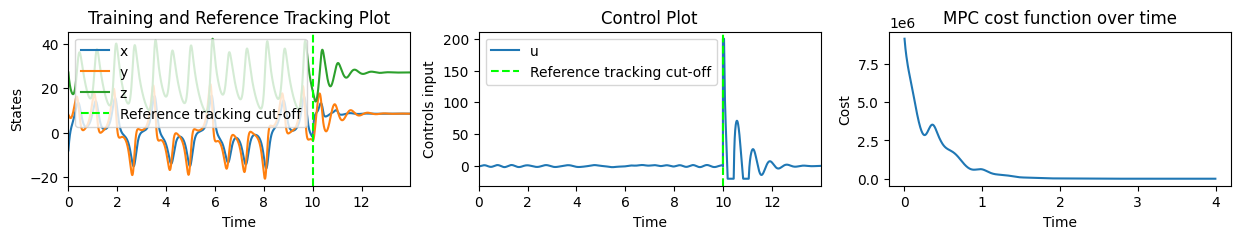

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

In [8]:
data_states = data_states_retrieve(states_hist)
data_controls = data_controls_retrieve(controls_hist)

fig, ax = plt.subplots(1, 3, figsize=(15, 2))
legend = ["x","y","z","Reference tracking cut-off"]
states_plot(system.t_train,system.x_train,t_hist,data_states,legend,ax[0])
controls_plot(system.t_train,system.u_train,t_hist,data_controls,ax[1])
cost_plot(t_hist[1:],cost_hist[1:],ax[2])
plt.show()

# Simple Population Dynamics <a id="SPD"></a>

The Lotka-Volterra equations, often referred to as the predator-prey equations, consist of a pair of first-order, nonlinear differential equations commonly applied to depict the behavior of biological systems involving the interaction of two species. Typically, one species is considered the predator, and the other is the prey. In the context of this notebook, the variables 'x' and 'y' are employed to represent the prey and predator populations, respectively. The primary objective here is to achieve the stabilization of these populations at specific values, namely x = 100 and y = 20.

\begin{align*}
& \dot{x} = ax - bxy\\
& \dot{y} = -ax + dxy + u
\end{align*}

In [9]:
class SimplePopulation:

    def __init__(self,a=0.5,b=0.025,c=0.5,d=0.005):
        # System parameters (Lorenz control)
        self.model_name = "Simple Population Dynamics"
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.discrete = False

    def train_data(self,t_end_train):
        # Training timespan
        self.dt = 0.002
        self.t_end_train = t_end_train
        self.t_train = np.arange(0,self.t_end_train,self.dt)
        self.x0_train = [200,15]
        self.t_train_span = (self.t_train[0], self.t_train[-1])
        
    def dynamics(self,t,x,u_func):
        x_dot = np.zeros((2,1))
        x_dot[0] = self.a*x[0] - self.b*x[0]*x[1]
        x_dot[1] = -self.c*x[1] + self.d*x[0]*x[1] + u_func(t)

        return x_dot

    # Control seqeuence
    def u_func(self,t):
        return np.column_stack([np.sin(2 * t)])
    
    def model_fit(self):
        # Integrator keywords
        integrator_keywords = {}
        integrator_keywords["rtol"] = 1e-12
        integrator_keywords["method"] = "LSODA"
        integrator_keywords["atol"] = 1e-12

        self.u_train = np.sin(2*self.t_train)
        u_func_partial = partial(self.u_func)
        self.x_train = solve_ivp(self.dynamics, self.t_train_span, self.x0_train, t_eval=self.t_train,
                                 **integrator_keywords,args=(u_func_partial,)).y.T
        feature_names = ["x","y","u"]

        ssr_optimizer = ps.SSR(alpha=0.05,criteria="model_residual",kappa=1e-1) # Optimizer SSR Greedy Optimiser
        library = ps.PolynomialLibrary(degree=2,include_bias=False) # Feature Library
        self.model = ps.SINDy(optimizer=ssr_optimizer,feature_library=library,
                            feature_names=feature_names,discrete_time=self.discrete)
        self.model.fit(x=self.x_train,u=self.u_train,t=self.dt)
        print(library.get_feature_names())
        print("Model Discovery (%s) :" % self.model_name)
        self.model.print()

In [10]:
# Weight matrix penalty
Q_x, Q_y = 5e1, 5e1
Q = ca.diagcat(Q_x, Q_y)
R1 = 1
R = ca.diagcat(R1)
dt, dt_simulate = 0.02, 0.01
N = 20 # Horizon
sim_time = 6     # simulation time
states_target = ca.DM([100,20]) # Unstable equilibrium point

# System parameters
a = 0.5
b = 0.025
c = 0.5
d = 0.005

# state symbolic variables
x, y = ca.SX.sym('x'), ca.SX.sym('y')
states = ca.vertcat(x,y)
# control symbolic variables
u = ca.SX.sym('u')
controls = ca.vertcat(u)

# state and controls contraints
x_lb = [0,0]
x_ub = [400,400]
u_lb = [-20]
u_ub = [20]

# Feature map
degree = 2
include_bias = False
states_concat = [x,y,u]   
library = SymbolicPolynomialLibrary()
library.fit(variables=states_concat,max_degree=degree,include_bias=include_bias)
states_mapped = library.get_feature_map()
library.print_feature_names()

# Model
system = SimplePopulation(a=a,b=b,c=c,d=d)
system.train_data(t_end_train=6)
system.model_fit()
A_estimate = system.model.coefficients()
A_true = np.array([[a, 0.0, 0.0, 0.0, -b, 0.0, 0.0, 0.0, 0.0],
                   [0.0, -c, 1, 0.0, d, 0.0, 0.0, 0.0, 0.0]])

# Set the initial state of the refrence tracking phase to the end of the training phase
print("Initial states (Reference Tracking)")
states_init = ca.DM(system.x_train[-1,:])
print(states_init)

Symbolic terms of the feature library (degree 2)
x,y,u,sq(x),(x*y),(x*u),sq(y),(y*u),sq(u),
['x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']
Model Discovery (Simple Population Dynamics) :
(x)' = 0.500 x + -0.025 x y
(y)' = -0.500 y + 1.000 u + 0.005 x y
Initial states (Reference Tracking)
[38.4436, 19.4806]


In [11]:
SimplePopulation_MPC = MPC(states=states,controls=controls,A_estimate=A_estimate,A_true=A_true,
                        states_mapped=states_mapped,states_init=states_init,N=N,
                        x_lb=x_lb,x_ub=x_ub,u_lb=u_lb,u_ub=u_ub,dt=dt,dt_simulate=dt_simulate,sim_time=sim_time)
SimplePopulation_MPC.initialize()
t_hist, states_hist, controls_hist, cost_hist = SimplePopulation_MPC.MPC_run(states_target=states_target)

Total CPU time: 11.241195 (s)
Average CPU iteration time: 37.274520 (ms)
Iteration (300)
final state discrepancy : 61.558549 
Final State : [99.87254895 19.9218862 ]


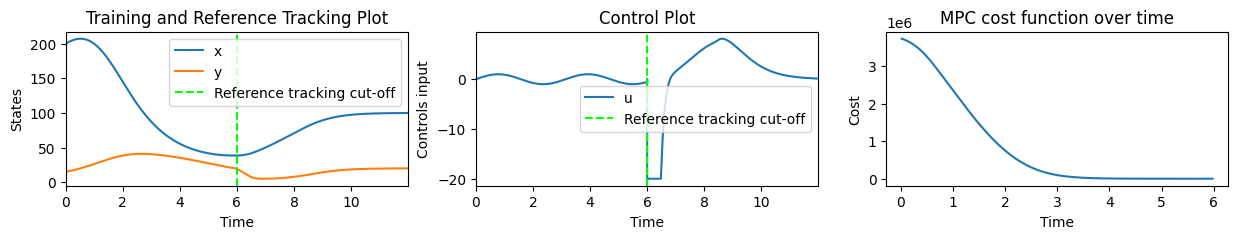

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

In [12]:
data_states = data_states_retrieve(states_hist)
data_controls = data_controls_retrieve(controls_hist)

fig, ax = plt.subplots(1, 3, figsize=(15, 2))
legend = ["x","y","Reference tracking cut-off"]
states_plot(system.t_train,system.x_train,t_hist,data_states,legend,ax[0])
controls_plot(system.t_train,system.u_train,t_hist,data_controls,ax[1])
cost_plot(t_hist[1:],cost_hist[1:],ax[2])
plt.show()

# HIV Model

The HIV model demonstrates the optimal drug therapy for inhibiting diseases such as cancer and viral infections. x1, x2, x3, x4, x5 refers to concentrations of  healthy CD4+ T-cells, HIV-infected CD4+ T-cells, CTL precursors (memory CTL), and helper-independent CTL. The primary goal is stabilise the dyanmical system at one of the steady-equilibrium point. [0.291, 3.333, 0, 0.091, 0]

\begin{align*}
& \dot{x_1} = \lambda - dx_1 - \beta(1-\eta u)x_1 x_2\\
& \dot{x_2} = \beta(1-\eta u)x_1 x_2 - ax_2 - p_1 x_4 x_2 - p_2 x_5 x_2\\
& \dot{x_3} = c_2 x_1 x_2 x_3 - c_2 q x_2 x_3 - b_2x_3\\
& \dot{x_4} = c_2 x_2 x_3 - b_1 x_4\\
& \dot{x_4} = c_2 q x_2 x_3 - h x_5\\
\end{align*}

In [13]:
class HIVModel:

    def __init__(self,lambda1,d,beta,a,p1,p2,c1,c2,b1,b2,q,h,eta):
        # System parameters (Lorenz control)
        self.model_name = "HIV Model"
        self.discrete = False
        self.lambda1 = lambda1
        self.d = d
        self.beta = beta
        self.a = a
        self.p1 = p1
        self.p2 = p2
        self.c1 = c1
        self.c2 = c2
        self.b1 = b1
        self.b2 = b2
        self.q = q
        self.h = h
        self.eta = eta

    def train_data(self,t_end_train,Pf=0.2,K=16):
        # Training timespan
        self.dt = 0.01
        self.t_end_train = t_end_train
        self.t_train = np.arange(0,self.t_end_train,self.dt)
        self.x0_train = [10, 0.1, 0.1, 0.1, 0.1]
        self.t_train_span = (self.t_train[0], self.t_train[-1])
        self.Pf = Pf # Fundamental period
        self.K = K
        
    def dynamics(self,t,x,u_func):
        u = u_func(t)
        x_dot = np.zeros((5, 1))
        x_dot[0] = self.lambda1 - self.d*x[0] - self.beta*(1 - self.eta*u)*x[0]*x[1]
        x_dot[1] = self.beta*(1 - self.eta*u)*x[1]*x[0] - self.a*x[1] - self.p1*x[3]*x[1] - self.p2*x[4]*x[1]
        x_dot[2] = self.c2*x[0]*x[1]*x[2] - self.c2*self.q*x[1]*x[2] - self.b2*x[2]
        x_dot[3] = self.c1*x[1]*x[3] - self.b1*x[3]
        x_dot[4] = self.c2*self.q*x[1]*x[2] - self.h*x[4]
        
        return x_dot
    
    # Control seqeuence
    def u_func(self,t):
        return np.column_stack([np.sin(2 * t)])

#     # Schroeder sweep
#     def u_func(self,t):
#         u = np.zeros_like(t)
#         for i in range(1, self.K+1):
#             theta = 2 * np.pi / self.K * np.sum(np.arange(1, i+1))
#             u += np.sqrt(2/self.K) * np.cos(2 * np.pi * i * t / self.Pf + theta)

#         return u
    
    
    def model_fit(self):
        # Integrator keywords
        integrator_keywords = {}
        integrator_keywords["rtol"] = 1e-12
        integrator_keywords["method"] = "LSODA"
        integrator_keywords["atol"] = 1e-12

        self.u_train = np.sin(2*self.t_train)
        u_func_partial = partial(self.u_func)
        self.x_train = solve_ivp(self.dynamics, self.t_train_span, self.x0_train, t_eval=self.t_train,
                                 **integrator_keywords,args=(u_func_partial,)).y.T

        # Very tedious and naive way of setting very "specific" feature library
        optimizer = ps.STLSQ(threshold=0.005)
        library_linear = ps.PolynomialLibrary(degree=1,include_bias=True) # Feature Library
        
        non_linear_functions1 = [lambda x,y: x*y]
        library_ab = ps.CustomLibrary(library_functions=non_linear_functions1)
        library_bc = ps.CustomLibrary(library_functions=non_linear_functions1) 
        library_bd = ps.CustomLibrary(library_functions=non_linear_functions1)
        library_be = ps.CustomLibrary(library_functions=non_linear_functions1) 
        
        non_linear_functions2 = [lambda x,y,z: x*y*z]
        library_abc = ps.CustomLibrary(library_functions=non_linear_functions2)         
        library_abd = ps.CustomLibrary(library_functions=non_linear_functions2)         
        library_abe = ps.CustomLibrary(library_functions=non_linear_functions2)         
        library_abu = ps.CustomLibrary(library_functions=non_linear_functions2)         
        
        
        n_libraries = 9
        inputs_temp = np.tile([0, 1, 2, 3, 4, 5], n_libraries)
        inputs_per_library = np.reshape(inputs_temp, (n_libraries, 6))
        inputs_per_library[1, 2], inputs_per_library[1, 3], inputs_per_library[1, 4], inputs_per_library[1, 5] = 1,1,1,1
        inputs_per_library[2, 0], inputs_per_library[2, 3], inputs_per_library[2, 4], inputs_per_library[2, 5] = 1,1,1,1
        inputs_per_library[3, 0], inputs_per_library[3, 2], inputs_per_library[3, 4], inputs_per_library[3, 5] = 1,1,1,1
        inputs_per_library[4, 0], inputs_per_library[4, 2], inputs_per_library[4, 3], inputs_per_library[4, 5] = 1,1,1,1
        
        inputs_per_library[5, 3], inputs_per_library[5, 4], inputs_per_library[5, 5] = 1,1,1
        inputs_per_library[6, 2], inputs_per_library[6, 4], inputs_per_library[6, 5] = 1,1,1
        inputs_per_library[7, 2], inputs_per_library[7, 3], inputs_per_library[7, 5] = 1,1,1
        inputs_per_library[8, 2], inputs_per_library[8, 3], inputs_per_library[8, 4] = 1,1,1
        library = ps.GeneralizedLibrary([library_linear,library_ab,library_bc,library_bd,library_be,
                                         library_abc,library_abd,library_abe,library_abu],inputs_per_library=inputs_per_library)
        feature_names = ["a","b","c","d","e","u"]
        
        self.model = ps.SINDy(optimizer=optimizer,feature_library=library,feature_names=feature_names,discrete_time=self.discrete)
        self.model.fit(x=self.x_train,u=self.u_train,t=self.dt)
        print(self.model.get_feature_names())
        print("Model Discovery (%s) :" % self.model_name)
        self.model.print()

In [14]:
# Weight matrix penalty
Q_a, Q_b, Q_c, Q_d, Q_e = 3e5, 3e5, 3e5, 3e5, 3e5
Q = ca.diagcat(Q_a, Q_b, Q_c, Q_d, Q_e)
R1 = 1
R = ca.diagcat(R1)
dt, dt_simulate = 0.04, 0.04
N = 5 # Horizon
sim_time = 200     # simulation time

# System parameters
lambda1_sys = 1
d_sys = 0.1
beta_sys = 1
a_sys = 0.2
p1_sys = 1
p2_sys = 1
c1_sys = 0.03
c2_sys = 0.06
b1_sys = 0.1
b2_sys = 0.01
q_sys = 0.5
h_sys = 0.1 
eta_sys = 0.9799 

# state symbolic variables
a, b, c, d, e = ca.SX.sym('a'), ca.SX.sym('b'), ca.SX.sym('c'), ca.SX.sym('d'), ca.SX.sym('e')
states = ca.vertcat(a,b,c,d,e)
# control symbolic variables
u = ca.SX.sym('u')
controls = ca.vertcat(u)

# state and controls contraints
x_lb = [-10000,-10000,-10000,-10000,-10000]
x_ub = [10000,10000,10000,10000,10000]
u_lb = [-10000]
u_ub = [10000]


# Feature map
states_mapped = [1,a,b,c,d,e,u,a*b,b*c,b*d,b*e,a*b*c,a*b*d,a*b*e,a*b*u]

# Model
system = HIVModel(lambda1=lambda1_sys,d=d_sys,beta=beta_sys,a=a_sys,p1=p1_sys,p2=p2_sys,
                  c1=c1_sys,c2=c2_sys,b1=b1_sys,b2=b2_sys,q=q_sys,h=h_sys,eta=eta_sys)
system.train_data(200)
system.model_fit()
A_estimate = system.model.coefficients()
A_true = np.array([[lambda1_sys, -d_sys, 0.0, 0.0, 0.0, 0.0, 0.0, -beta_sys, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, beta_sys*eta_sys],
                   [0.0, 0.0, -a_sys, 0.0, 0.0, 0.0, 0.0, beta_sys, 0.0, -p1_sys, -p2_sys, 0.0, 0.0, 0.0, -beta_sys*eta_sys],
                   [0.0, 0.0, 0.0, -b2_sys, 0.0, 0.0, 0.0, 0.0, -c2_sys*q_sys, 0.0, 0.0, c2_sys, 0.0, 0.0, 0.0],
                   [0.0, 0.0, 0.0, 0.0, -b1_sys, 0.0, 0.0, 0.0, 0.0, c1_sys, 0.0, 0.0, 0.0, 0.0, 0.0],
                   [0.0, 0.0, 0.0, 0.0, 0.0, -h_sys, 0.0, 0.0, c2_sys*q_sys, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

# states_init = ca.DM(system.x_train[-1,:])
states_init = ca.DM([10, 0.1, 0.1, 0.1, 0.1])
states_target = ca.DM([0.291262135922330, 3.33333333333333, 0, 0.0912621359223301, 0])
print("Initial reference tracking state : ",states_init)

['1', 'a', 'b', 'c', 'd', 'e', 'u', 'f0(a,b)', 'f0(b,c)', 'f0(b,d)', 'f0(b,e)', 'f0(a,b,c)', 'f0(a,b,d)', 'f0(a,b,e)', 'f0(a,b,u)']
Model Discovery (HIV Model) :
(a)' = 1.000 1 + -0.100 a + -1.000 f0(a,b) + 0.980 f0(a,b,u)
(b)' = -0.200 b + 1.000 f0(a,b) + -1.000 f0(b,d) + -1.000 f0(b,e) + -0.980 f0(a,b,u)
(c)' = -0.010 c + -0.030 f0(b,c) + 0.060 f0(a,b,c)
(d)' = -0.100 d + 0.030 f0(b,d)
(e)' = -0.100 e + 0.030 f0(b,c)
Initial reference tracking state :  [10, 0.1, 0.1, 0.1, 0.1]


In [15]:
HIVModel_MPC = MPC(states=states,controls=controls,A_estimate=A_estimate,A_true=A_true,
                        states_mapped=states_mapped,states_init=states_init,N=N,
                        x_lb=x_lb,x_ub=x_ub,u_lb=u_lb,u_ub=u_ub,dt=dt,dt_simulate=dt_simulate,sim_time=sim_time)
HIVModel_MPC.initialize()
t_hist, states_hist, controls_hist, cost_hist = HIVModel_MPC.MPC_run(states_target=states_target)

Total CPU time: 165.914627 (s)
Average CPU iteration time: 33.093400 (ms)
Iteration (5000)
final state discrepancy : 10.233969 
Final State : [3.68677384e-01 3.41275289e+00 1.19936562e-03 8.10546918e-02
 1.85557737e-03]


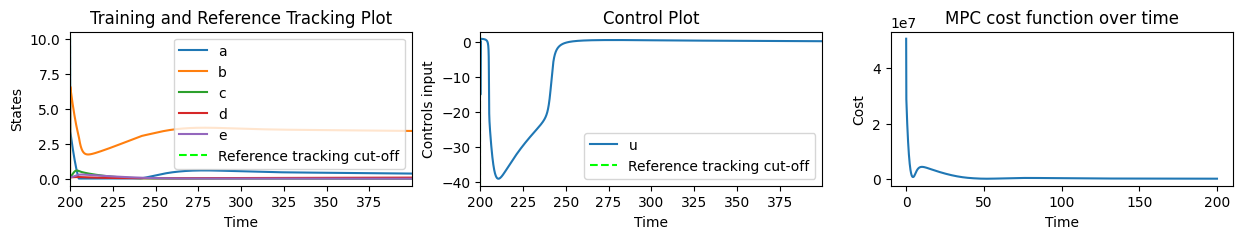

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

<Figure size 960x720 with 0 Axes>

In [16]:
data_states = data_states_retrieve(states_hist)
data_controls = data_controls_retrieve(controls_hist)

fig, ax = plt.subplots(1, 3, figsize=(15, 2))
legend = ["a","b","c","d","e","Reference tracking cut-off"]
states_plot(system.t_train,system.x_train,t_hist,data_states,legend,ax[0],include_training=False)
controls_plot(system.t_train,system.u_train,t_hist,data_controls,ax[1],include_training=False)
cost_plot(t_hist[1:],cost_hist[1:],ax[2])
plt.show()